In [9]:
import numpy as np
import pandas as pd
import os
import json

import pickle
!pip install cornac
import cornac
from sklearn.model_selection import train_test_split as sk_split

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
#!pip install tensorflow_ranking
!pip install tensorflow-gpu


  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [11]:
import tensorflow as tf

# Check if a GPU is available
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [12]:
reviews = pd.read_csv('/content/drive/MyDrive/Datasets/ratings.dat', names=['userId', 'movieId', 'rating', 'time'], delimiter='::', engine='python')
movies = pd.read_csv('/content/drive/MyDrive/Datasets/movies.dat', names=['movieId', 'movie_names', 'genres'], delimiter='::', encoding='ISO-8859-1')
users = pd.read_csv('/content/drive/MyDrive/Datasets/users.dat', names=['userId', 'gender', 'age', 'occupation', 'zip'], delimiter='::', engine='python')

# we drop users' zip code because we will not use it
users.drop(['zip'], axis=1, inplace=True)

movielens_df = reviews.merge(movies, on='movieId', how='left').merge(users, on='userId', how='left')

print('Merged dataframe shape:', movielens_df.shape)

threshold = 3
movielens_df['implicit_feedback'] = (movielens_df['rating'] >= threshold).astype(int)

# we work with implicit feedback so we do not need any other information (in article threshold == 1 (they count all intercations as positive feedback))
movielens_df.rename(columns = {'movieId':'itemId'}, inplace = True )
movielens_df.drop(columns = ['movie_names', 'genres',	'gender',	'age',	'occupation',	'implicit_feedback'], inplace=True)

<ipython-input-12-f51c6bea116d>:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  movies = pd.read_csv('/content/drive/MyDrive/Datasets/movies.dat', names=['movieId', 'movie_names', 'genres'], delimiter='::', encoding='ISO-8859-1')


Merged dataframe shape: (1000209, 9)


In [13]:




# @title TrainTest split

def python_random_split(data, ratio=0.75, seed=42):
    """Pandas random splitter
    input data를 랜덤하게 나누는 함수

    Args:
        data (pd.DataFrame): Pandas DataFrame to be split.
        ratio (float or list): Ratio for splitting data. If it is a single float number
            it splits data into two halves and the ratio argument indicates the ratio
            of training data set; if it is a list of float numbers, the splitter splits
            data into several portions corresponding to the split ratios. If a list is
            provided and the ratios are not summed to 1, they will be normalized.
        seed (int): Seed.

    Returns:
        list: 나누어진 input data (pd.DataFrame)
    """
    multi_split, ratio = process_split_ratio(ratio)

    if multi_split:
        splits = split_pandas_data_with_ratios(data, ratio, shuffle=True, seed=seed)
        splits_new = [x.drop('split_index', axis=1) for x in splits]

        return splits_new
    else:
        return sk_split(data, test_size=None, train_size=ratio, random_state=seed)

def process_split_ratio(ratio):
    """Generate split ratio lists

    Args:
        ratio (float or list): a float number that indicates split ratio or a list of float
        numbers that indicate split ratios (if it is a multi-split).

    Returns:
        tuple: a tuple containing
            bool: A boolean variable multi that indicates if the splitting is multi or single.
            list: A list of normalized split ratios.
    """
    if isinstance(ratio, float):
        if ratio <= 0 or ratio >= 1:
            raise ValueError("Split ratio has to be between 0 and 1")

        multi = False
    elif isinstance(ratio, list):
        if any([x <= 0 for x in ratio]):
            raise ValueError(
                "All split ratios in the ratio list should be larger than 0."
            )

        # normalize split ratios if they are not summed to 1
        if sum(ratio) != 1.0:
            ratio = [x / sum(ratio) for x in ratio]

        multi = True
    else:
        raise TypeError("Split ratio should be either float or a list of floats.")

    return multi, ratio

def split_pandas_data_with_ratios(data, ratios, seed=42, shuffle=False):
    """Helper function to split pandas DataFrame with given ratios

    Note:
        Implementation referenced from
        https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test

    Args:
        data (pd.DataFrame): Pandas data frame to be split.
        ratios (list of floats): list of ratios for split. The ratios have to sum to 1.
        seed (int): random seed.
        shuffle (bool): whether data will be shuffled when being split.

    Returns:
        list: List of pd.DataFrame split by the given specifications.
    """
    if sum(ratios) != 1.0:
        raise ValueError("The ratios have to sum to 1")

    split_index = np.cumsum(ratios).tolist()[:-1]

    if shuffle:
        data = data.sample(frac=1, random_state=seed)

    splits = np.split(data, [round(x * len(data)) for x in split_index])

    # Add split index (this makes splitting by group more efficient).
    for i in range(len(ratios)):
        splits[i]["split_index"] = i

    return splits



# @title Timer
from timeit import default_timer


class Timer(object):
    """Timer class.

    `Original code <https://github.com/miguelgfierro/pybase/blob/2298172a13fb4a243754acbc6029a4a2dcf72c20/log_base/timer.py>`_.

    Examples:
        >>> import time
        >>> t = Timer()
        >>> t.start()
        >>> time.sleep(1)
        >>> t.stop()
        >>> t.interval < 1
        True
        >>> with Timer() as t:
        ...   time.sleep(1)
        >>> t.interval < 1
        True
        >>> "Time elapsed {}".format(t) #doctest: +ELLIPSIS
        'Time elapsed 1...'
    """

    def __init__(self):
        self._timer = default_timer
        self._interval = 0
        self.running = False

    def __enter__(self):
        self.start()
        return self

    def __exit__(self, *args):
        self.stop()

    def __str__(self):
        return "{:0.4f}".format(self.interval)

    def start(self):
        """Start the timer."""
        self.init = self._timer()
        self.running = True

    def stop(self):
        """Stop the timer. Calculate the interval in seconds."""
        self.end = self._timer()
        try:
            self._interval = self.end - self.init
            self.running = False
        except AttributeError:
            raise ValueError(
                "Timer has not been initialized: use start() or the contextual form with Timer() as t:"
            )

    @property
    def interval(self):
        """Get time interval in seconds.

        Returns:
            float: Seconds.
        """
        if self.running:
            raise ValueError("Timer has not been stopped, please use stop().")
        else:
            return self._interval


# @title Predict_ranking
def predict_ranking(
    model,
    data,
    usercol='userId',
    itemcol='movieId',
    predcol='prediction',
    remove_seen=False,
):
    """Computes predictions of recommender model from Cornac on all users and items in data.
    It can be used for computing ranking metrics like NDCG.

    Args:
        model (cornac.models.Recommender): A recommender model from Cornac
        data (pandas.DataFrame): The data from which to get the users and items
        usercol (str): Name of the user column
        itemcol (str): Name of the item column
        remove_seen (bool): Flag to remove (user, item) pairs seen in the training data

    Returns:
        pandas.DataFrame: Dataframe with usercol, itemcol, predcol
    """
    users, items, preds = [], [], []
    item = list(model.train_set.iid_map.keys())
    for uid, user_idx in model.train_set.uid_map.items():
        user = [uid] * len(item)
        users.extend(user)
        items.extend(item)
        preds.extend(model.score(user_idx).tolist())

    all_predictions = pd.DataFrame(
        data={usercol: users, itemcol: items, predcol: preds}
    )

    if remove_seen:
        tempdf = pd.concat(
            [
                data[[usercol, itemcol]],
                pd.DataFrame(
                    data=np.ones(data.shape[0]), columns=["dummycol"], index=data.index
                ),
            ],
            axis=1,
        )
        merged = pd.merge(tempdf, all_predictions, on=[usercol, itemcol], how="outer")
        return merged[merged["dummycol"].isnull()].drop("dummycol", axis=1)
    else:
        return all_predictions



# @title RECALL and  NDCG
def recall_at_k(
    rating_true,
    rating_pred,
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
    col_prediction=DEFAULT_PREDICTION_COL,
    relevancy_method="top_k",
    k=DEFAULT_K,
    threshold=DEFAULT_THRESHOLD,
    **kwargs
):
    """Recall at K.

    Args:
        rating_true (pandas.DataFrame): True DataFrame
        rating_pred (pandas.DataFrame): Predicted DataFrame
        col_user (str): column name for user
        col_item (str): column name for item
        col_rating (str): column name for rating
        col_prediction (str): column name for prediction
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the
            top k items are directly provided, so there is no need to compute the relevancy operation.
        k (int): number of top k items per user
        threshold (float): threshold of top items per user (optional)

    Returns:
        float: recall at k (min=0, max=1). The maximum value is 1 even when fewer than
        k items exist for a user in rating_true.
    """
    col_rating = _get_rating_column(relevancy_method, **kwargs)
    df_hit, df_hit_count, n_users = merge_ranking_true_pred(
        rating_true=rating_true,
        rating_pred=rating_pred,
        col_user=col_user,
        col_item=col_item,
        col_rating=col_rating,
        col_prediction=col_prediction,
        relevancy_method=relevancy_method,
        k=k,
        threshold=threshold,
    )

    if df_hit.shape[0] == 0:
        return 0.0

    return (df_hit_count["hit"] / df_hit_count["actual"]).sum() / n_users

def ndcg_at_k(
    rating_true,
    rating_pred,
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
    col_prediction=DEFAULT_PREDICTION_COL,
    relevancy_method="top_k",
    k=DEFAULT_K,
    threshold=DEFAULT_THRESHOLD,
    score_type="binary",
    discfun_type="loge",
    **kwargs
):
    """Normalized Discounted Cumulative Gain (nDCG).

    Info: https://en.wikipedia.org/wiki/Discounted_cumulative_gain

    Args:
        rating_true (pandas.DataFrame): True DataFrame
        rating_pred (pandas.DataFrame): Predicted DataFrame
        col_user (str): column name for user
        col_item (str): column name for item
        col_rating (str): column name for rating
        col_prediction (str): column name for prediction
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the
            top k items are directly provided, so there is no need to compute the relevancy operation.
        k (int): number of top k items per user
        threshold (float): threshold of top items per user (optional)
        score_type (str): type of relevance scores ['binary', 'raw', 'exp']. With the default option 'binary', the
            relevance score is reduced to either 1 (hit) or 0 (miss). Option 'raw' uses the raw relevance score.
            Option 'exp' uses (2 ** RAW_RELEVANCE - 1) as the relevance score
        discfun_type (str): type of discount function ['loge', 'log2'] used to calculate DCG.

    Returns:
        float: nDCG at k (min=0, max=1).
    """
    col_rating = _get_rating_column(relevancy_method, **kwargs)
    df_hit, _, _ = merge_ranking_true_pred(
        rating_true=rating_true,
        rating_pred=rating_pred,
        col_user=col_user,
        col_item=col_item,
        col_rating=col_rating,
        col_prediction=col_prediction,
        relevancy_method=relevancy_method,
        k=k,
        threshold=threshold,
    )

    if df_hit.shape[0] == 0:
        return 0.0

    df_dcg = df_hit.merge(rating_pred, on=[col_user, col_item]).merge(
        rating_true, on=[col_user, col_item], how="outer", suffixes=("_left", None)
    )

    if score_type == "binary":
        df_dcg["rel"] = 1
    elif score_type == "raw":
        df_dcg["rel"] = df_dcg[col_rating]
    elif score_type == "exp":
        df_dcg["rel"] = 2 ** df_dcg[col_rating] - 1
    else:
        raise ValueError("score_type must be one of 'binary', 'raw', 'exp'")

    if discfun_type == "loge":
        discfun = np.log
    elif discfun_type == "log2":
        discfun = np.log2
    else:
        raise ValueError("discfun_type must be one of 'loge', 'log2'")

    # Calculate the actual discounted gain for each record
    df_dcg["dcg"] = df_dcg["rel"] / discfun(1 + df_dcg["rank"])

    # Calculate the ideal discounted gain for each record
    df_idcg = df_dcg.sort_values([col_user, col_rating], ascending=False)
    df_idcg["irank"] = df_idcg.groupby(col_user, as_index=False, sort=False)[
        col_rating
    ].rank("first", ascending=False)
    df_idcg["idcg"] = df_idcg["rel"] / discfun(1 + df_idcg["irank"])

    # Calculate the actual DCG for each user
    df_user = df_dcg.groupby(col_user, as_index=False, sort=False).agg({"dcg": "sum"})

    # Calculate the ideal DCG for each user
    df_user = df_user.merge(
        df_idcg.groupby(col_user, as_index=False, sort=False)
        .head(k)
        .groupby(col_user, as_index=False, sort=False)
        .agg({"idcg": "sum"}),
        on=col_user,
    )

    # DCG over IDCG is the normalized DCG
    df_user["ndcg"] = df_user["dcg"] / df_user["idcg"]
    return df_user["ndcg"].mean()

def merge_ranking_true_pred(
    rating_true,
    rating_pred,
    col_user,
    col_item,
    col_rating,
    col_prediction,
    relevancy_method,
    k=DEFAULT_K,
    threshold=DEFAULT_THRESHOLD,
):
    """Filter truth and prediction data frames on common users

    Args:
        rating_true (pandas.DataFrame): True DataFrame
        rating_pred (pandas.DataFrame): Predicted DataFrame
        col_user (str): column name for user
        col_item (str): column name for item
        col_rating (str): column name for rating
        col_prediction (str): column name for prediction
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the
            top k items are directly provided, so there is no need to compute the relevancy operation.
        k (int): number of top k items per user (optional)
        threshold (float): threshold of top items per user (optional)

    Returns:
        pandas.DataFrame, pandas.DataFrame, int: DataFrame of recommendation hits, sorted by `col_user` and `rank`
        DataFrame of hit counts vs actual relevant items per user number of unique user ids
    """

    # Make sure the prediction and true data frames have the same set of users
    common_users = set(rating_true[col_user]).intersection(set(rating_pred[col_user]))
    rating_true_common = rating_true[rating_true[col_user].isin(common_users)]
    rating_pred_common = rating_pred[rating_pred[col_user].isin(common_users)]
    n_users = len(common_users)

    # Return hit items in prediction data frame with ranking information. This is used for calculating NDCG and MAP.
    # Use first to generate unique ranking values for each item. This is to align with the implementation in
    # Spark evaluation metrics, where index of each recommended items (the indices are unique to items) is used
    # to calculate penalized precision of the ordered items.
    if relevancy_method == "top_k":
        top_k = k
    elif relevancy_method == "by_threshold":
        top_k = threshold
    elif relevancy_method is None:
        top_k = None
    else:
        raise NotImplementedError("Invalid relevancy_method")
    df_hit = get_top_k_items(
        dataframe=rating_pred_common,
        col_user=col_user,
        col_rating=col_prediction,
        k=top_k,
    )
    df_hit = pd.merge(df_hit, rating_true_common, on=[col_user, col_item])[
        [col_user, col_item, "rank"]
    ]

    # count the number of hits vs actual relevant items per user
    df_hit_count = pd.merge(
        df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
        rating_true_common.groupby(col_user, as_index=False)[col_user].agg(
            {"actual": "count"}
        ),
        on=col_user,
    )

    return df_hit, df_hit_count, n_users

def get_top_k_items(
    dataframe, col_user=DEFAULT_USER_COL, col_rating=DEFAULT_RATING_COL, k=DEFAULT_K
):
    """Get the input customer-item-rating tuple in the format of Pandas
    DataFrame, output a Pandas DataFrame in the dense format of top k items
    for each user.

    Note:
        If it is implicit rating, just append a column of constants to be
        ratings.

    Args:
        dataframe (pandas.DataFrame): DataFrame of rating data (in the format
        customerID-itemID-rating)
        col_user (str): column name for user
        col_rating (str): column name for rating
        k (int or None): number of items for each user; None means that the input has already been
        filtered out top k items and sorted by ratings and there is no need to do that again.

    Returns:
        pandas.DataFrame: DataFrame of top k items for each user, sorted by `col_user` and `rank`
    """
    # Sort dataframe by col_user and (top k) col_rating
    if k is None:
        top_k_items = dataframe
    else:
        top_k_items = (
            dataframe.sort_values([col_user, col_rating], ascending=[True, False])
            .groupby(col_user, as_index=False)
            .head(k)
            .reset_index(drop=True)
        )
    # Add ranks
    top_k_items["rank"] = top_k_items.groupby(col_user, sort=False).cumcount() + 1
    return top_k_items

def _get_rating_column(relevancy_method: str, **kwargs) -> str:
    r"""Helper utility to simplify the arguments of eval metrics
    Attemtps to address https://github.com/microsoft/recommenders/issues/1737.

    Args:
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the
            top k items are directly provided, so there is no need to compute the relevancy operation.

    Returns:
        str: rating column name.
    """
    if relevancy_method != "top_k":
        if "col_rating" not in kwargs:
            raise ValueError("Expected an argument `col_rating` but wasn't found.")
        col_rating = kwargs.get("col_rating")
    else:
        col_rating = kwargs.get("col_rating", DEFAULT_RATING_COL)
    return col_rating


In [14]:
DEFAULT_USER_COL = 'userId'
DEFAULT_ITEM_COL = 'itemId'
DEFAULT_PREDICTION_COL = 'prediction'
DEFAULT_RATING_COL = 'rating'
DEFAULT_K = 10
DEFAULT_THRESHOLD = 1

EPOCHS_NUM = 1000
SEED = 12

In [15]:
# Set the random seed for reproducibility
import random
random.seed(12)
np.random.seed(12)
tf.random.set_seed(12)

In [16]:
train_data, test_data = python_random_split(movielens_df, 0.80)


In [17]:
# Pseudo-code for APR Model based on your existing BPR Model

import tensorflow as tf
from tensorflow.keras.layers import Embedding, Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Input, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import Sequence
import random
from tqdm import tqdm
from collections import defaultdict




class MovieLensDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, user_item_pairs, num_items, batch_size=1064, shuffle=True):
        self.user_item_pairs = user_item_pairs  # Pass user_item_pairs as a parameter
        self.num_items = num_items
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.user_item_pairs))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.user_item_pairs) / self.batch_size))

    def __getitem__(self, index):
      indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
      user_item_pairs_batch = [self.user_item_pairs[k] for k in indexes]

      user_ids = []
      pos_item_ids = []
      neg_item_ids = []

      for user_id, item_id in user_item_pairs_batch:
          user_ids.append(user_id)
          pos_item_ids.append(item_id)
          # Sample a negative item (the user has not interacted with)
          while True:
              neg_item_id = random.randint(0, self.num_items - 1)
              if neg_item_id not in self.user_item_pairs[user_id]:
                  break
          neg_item_ids.append(neg_item_id)

      return [np.array(user_ids), np.array(pos_item_ids), np.array(neg_item_ids)], np.ones((len(user_ids),))  # Return labels as a tensor




    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
# Define the BPR Loss class
class BPR_Loss(tf.keras.losses.Loss):
    def call(self, y_true, y_pred):
        pos_preds, neg_preds = tf.split(y_pred, 2, axis=1)
        loss = -tf.reduce_mean(tf.math.log_sigmoid(pos_preds - neg_preds))
        return loss
class AdversarialPersonalizedRanking(Model):
    def __init__(self, num_users, num_items, latent_dim, l2_reg=0.0, rho=0.5, alpha=0.0, epsilon=0.01):
        super(AdversarialPersonalizedRanking, self).__init__()
        self.latent_dim = latent_dim
        self.rho = rho  # Magnitude of adversarial perturbations
        self.alpha = alpha  # Weight for combining BPR and adversarial loss
        self.epsilon = epsilon  # Magnitude of adversarial perturbation
        self.user_embedding = Embedding(num_users, self.latent_dim, embeddings_regularizer=l2(l2_reg))
        self.item_embedding = Embedding(num_items, self.latent_dim, embeddings_regularizer=l2(l2_reg))

    def call(self, inputs, training=False):
        user_indices, item_indices = inputs
        user_embedding = self.user_embedding(user_indices)
        item_embedding = self.item_embedding(item_indices)
        scores = tf.reduce_sum(user_embedding * item_embedding, axis=1, keepdims=True)
        return scores




    def add_adversarial_perturbation(self, gradient):
        # Normalize the gradient, which is important for the method
        gradient = tf.nn.l2_normalize(gradient, axis=None)
        # Add adversarial perturbation to the embeddings
        self.user_embedding.weights[0].assign_add(self.epsilon * gradient)

    def train_step(self, data):
        # Unpack the data
        inputs, y_true = data
        user_indices, pos_item_indices, neg_item_indices = inputs

        # Forward pass and compute BPR loss
        with tf.GradientTape() as tape:
            user_embedding = self.user_embedding(user_indices)
            pos_item_embedding = self.item_embedding(pos_item_indices)
            neg_item_embedding = self.item_embedding(neg_item_indices)

            pos_scores = tf.reduce_sum(user_embedding * pos_item_embedding, axis=1, keepdims=True)
            neg_scores = tf.reduce_sum(user_embedding * neg_item_embedding, axis=1, keepdims=True)

            y_pred = tf.concat([pos_scores, neg_scores], axis=1)
            bpr_loss = BPR_Loss()(y_true, y_pred)

        # Get trainable variables
        trainable_vars = self.trainable_variables

        # Compute gradients of BPR loss w.r.t. trainable variables
        gradients = tape.gradient(bpr_loss, self.trainable_variables)
        for var, grad in zip(self.trainable_variables, gradients):
            if grad is None:
                print(f"Gradient for {var.name} is None")

        # Check if any gradients are None and skip if so
        if any(g is None for g in gradients):
            return {"loss": bpr_loss}

        # Apply original gradients
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Re-compute the embeddings for adversarial perturbation
        with tf.GradientTape() as tape_adv:
            tape_adv.watch(trainable_vars)
            user_embedding_adv = self.user_embedding(user_indices)
            pos_item_embedding_adv = self.item_embedding(pos_item_indices)
            neg_item_embedding_adv = self.item_embedding(neg_item_indices)

            pos_scores_adv = tf.reduce_sum(user_embedding_adv * pos_item_embedding_adv, axis=1, keepdims=True)
            neg_scores_adv = tf.reduce_sum(user_embedding_adv * neg_item_embedding_adv, axis=1, keepdims=True)

            y_pred_adv = tf.concat([pos_scores_adv, neg_scores_adv], axis=1)
            adv_loss = BPR_Loss()(y_true, y_pred_adv)

        # Combine BPR and adversarial loss
        combined_loss = self.alpha * bpr_loss + (1 - self.alpha) * adv_loss

        # Compute gradients of combined loss
        combined_gradients = tape_adv.gradient(combined_loss, trainable_vars)

        # Check if any combined gradients are None and skip if so
        if any(g is None for g in combined_gradients):
            return {"loss": combined_loss}

        # Apply combined gradients
        self.optimizer.apply_gradients(zip(combined_gradients, trainable_vars))

        # Return a dict mapping metric names to current value
        return {"loss": combined_loss}


    def test_step(self, data):
        # Unpack the data
        user_indices, pos_item_indices, neg_item_indices, y_true = data
        # Compute predictions
        y_pred = self([user_indices, pos_item_indices, neg_item_indices], training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y_true, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y_true, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}


def predictions_to_df(model, test_data_generator, user_col, item_col):
    all_user_indices = []
    all_item_indices = []
    all_predictions = []

    for batch in test_data_generator:
        user_indices, pos_item_indices, neg_item_indices = batch[0]

        # Generate predictions
        y_pred = model.predict([user_indices, pos_item_indices, neg_item_indices])
        all_user_indices.extend(user_indices.numpy())
        all_item_indices.extend(pos_item_indices.numpy())
        all_predictions.extend(y_pred[:, 0])  # Assuming positive scores are in the first column

    return pd.DataFrame({
        user_col: all_user_indices,
        item_col: all_item_indices,
        'prediction': all_predictions
    })
def generate_predictions(model, user_indices, item_indices, train_data, user_col, item_col, remove_seen=False):
    preds = []
    for user in user_indices:
        for item in item_indices:
            # Check if user-item pair is in the training data
            if remove_seen and not train_data[(train_data[user_col] == user) & (train_data[item_col] == item)].empty:
                continue

            # Generate prediction for each user-item pair
            user_array = np.array([user])
            item_array = np.array([item])
            pred = model.predict([user_array, item_array])
            preds.append([user, item, pred[0][0]])  # Assuming the model outputs a single score

    prediction_df = pd.DataFrame(preds, columns=[user_col, item_col, 'prediction'])
    return prediction_df


def predict_ranking_custom(model, data, usercol, itemcol, num_items, batch_size=1024, remove_seen=False):
    def generate_user_item_pairs(data, usercol, itemcol, num_items):
        seen_pairs = set(zip(data[usercol], data[itemcol])) if remove_seen else set()
        for user in data[usercol].unique():
            for item in range(num_items):
                if (user, item) not in seen_pairs:
                    yield (user, item)

    # Generator for user-item pairs
    pairs_generator = generate_user_item_pairs(data, usercol, itemcol, num_items)

    # Process in batches
    def batch_generator(generator, batch_size):
        users_batch, items_batch = [], []
        for user, item in generator:
            users_batch.append(user)
            items_batch.append(item)
            if len(users_batch) == batch_size:
                yield np.array(users_batch), np.array(items_batch)
                users_batch, items_batch = [], []
        if users_batch:
            yield np.array(users_batch), np.array(items_batch)

    # Predict in batches and collect results
    all_users, all_items, all_predictions = [], [], []
    for users, items in batch_generator(pairs_generator, batch_size):
        # Inside the predict_ranking_custom function
        predictions = model.predict([users, items])[:, 0]
        # Adjust based on your model's specifics
        all_users.extend(users)
        all_items.extend(items)
        all_predictions.extend(predictions)

    return pd.DataFrame({usercol: all_users, itemcol: all_items, 'prediction': all_predictions})

DEFAULT_USER_COL = 'userId'
DEFAULT_ITEM_COL = 'itemId'
DEFAULT_PREDICTION_COL = 'prediction'
DEFAULT_RATING_COL = 'rating'
DEFAULT_K = 10
DEFAULT_THRESHOLD = 1



In [ ]:
from collections import defaultdict
from sklearn.model_selection import train_test_split
num_users = movielens_df['userId'].nunique() + 1
num_items = movielens_df['itemId'].nunique() + 1
train_user_positive_items = defaultdict(set)
test_user_positive_items = defaultdict(set)

for row in train_data.itertuples():
    train_user_positive_items[row.userId].add(row.itemId)

for row in test_data.itertuples():
    test_user_positive_items[row.userId].add(row.itemId)

# Create user-item pairs for the data generator for training
train_user_item_pairs = [(row.userId, row.itemId) for row in train_data.itertuples()]

# Create user-item pairs for the data generator for testing
test_user_item_pairs = [(row.userId, row.itemId) for row in test_data.itertuples()]

# Rest of your code remains the same
num_users = movielens_df['userId'].nunique() + 1
num_items = movielens_df['itemId'].nunique() + 1
latent_dim = 128
batch_size = 1024

train_data_generator = MovieLensDataGenerator(
    user_item_pairs=train_user_item_pairs,
    num_items=num_items,
    batch_size=batch_size,
    shuffle=True
)

# Create the data generator for testing
test_data_generator = MovieLensDataGenerator(
    user_item_pairs=test_user_item_pairs,
    num_items=num_items,
    batch_size=batch_size,
    shuffle=True
)


#alphas = [0, 0.1, 0.01, 1, 10, 100, 1000, float('inf')]
alphas = [1000]
rho = 0.5 # Magnitude of adversarial perturbations
performance_records = []
epochs = 400
loss_values = []
with tf.device('/GPU:0'):
    for alpha in alphas:
        # Create and train the model

        model = AdversarialPersonalizedRanking(num_users, num_items, latent_dim, l2_reg=0.01, rho=rho)
        model.compile(optimizer='adam', loss=BPR_Loss())
        model.alpha = alpha  # Set the current alpha

        for epoch in tqdm(range(epochs), desc=f"Training with alpha={alpha}"):
            epoch_loss = 0
            batches = 0
            for batch in train_data_generator:
                #model.train_step(batch)
                batch_loss = model.train_step(batch)
                epoch_loss += batch_loss["loss"]
                batches += 1
            epoch_loss /= batches
            loss_values.append(epoch_loss)

        # Generate predictions using the custom function
        all_predictions = predict_ranking_custom(model, train_data, usercol='userId', itemcol='itemId', num_items=num_items, batch_size=1024, remove_seen=True)

        # Calculate metrics using the test data
        eval_ndcg = ndcg_at_k(test_data, all_predictions, col_prediction='prediction', k=20)
        eval_recall = recall_at_k(test_data, all_predictions, col_prediction='prediction', k=20)

        performance_records.append((alpha, eval_recall, eval_ndcg))
        print("Performance: ",performance_records)




Training with alpha=1000:  57%|█████▋    | 228/400 [1:16:26<57:15, 19.97s/it]

In [4]:
gowalla_df = pd.read_csv('/content/drive/MyDrive/Datasets/Gowalla_totalCheckins.txt', sep='\t', header=None)
gowalla_df.columns = ['userid','timestamp','latitude','longitude','spotid']
gowalla_df.head()

,userid,timestamp,latitude,longitude,spotid
0,0,2010-10-19T23:55:27Z,30.235909,-97.795140,22847
1,0,2010-10-18T22:17:43Z,30.269103,-97.749395,420315
2,0,2010-10-17T23:42:03Z,30.255731,-97.763386,316637
3,0,2010-10-17T19:26:05Z,30.263418,-97.757597,16516
4,0,2010-10-16T18:50:42Z,30.274292,-97.740523,5535878


In [5]:
# Drop not useful columns
gowalla_df.drop(['timestamp', 'latitude', 'longitude'], axis=1, inplace=True)
# Filter users and spots with at least 10 interactions
min_interactions = 10
user_counts = gowalla_df['userid'].value_counts()
spot_counts = gowalla_df['spotid'].value_counts()

# Filter users and spots with at least 10 interactions
gowalla_df = gowalla_df[gowalla_df['userid'].isin(user_counts[user_counts >= min_interactions].index)]
gowalla_df = gowalla_df[gowalla_df['spotid'].isin(spot_counts[spot_counts >= min_interactions].index)]

# Reset index
gowalla_df.reset_index(drop=True, inplace=True)

In [6]:
gowalla_df.head()

,userid,spotid
0,0,22847
1,0,420315
2,0,316637
3,0,16516
4,0,5535878


In [7]:
gowalla_df['rating'] = 2

<ipython-input-7-271619c7a458>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gowalla_df['rating'] = 2


In [8]:
gowalla_df.rename(columns = {'userid':'userId', 'spotid':'itemId'}, inplace = True )

<ipython-input-8-fe918930cf1a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gowalla_df.rename(columns = {'userid':'userId', 'spotid':'itemId'}, inplace = True )


In [9]:
gowalla_df.head()

,userId,itemId,rating
0,0,22847,2
1,0,420315,2
2,0,316637,2
3,0,16516,2
4,0,5535878,2


In [10]:
gowalla_df = gowalla_df.drop(gowalla_df.index.to_list()[100000:], axis=0)

In [11]:
DEFAULT_USER_COL = 'userId'
DEFAULT_ITEM_COL = 'itemId'
DEFAULT_PREDICTION_COL = 'prediction'
DEFAULT_RATING_COL = 'rating'
DEFAULT_K = 10
DEFAULT_THRESHOLD = 1

EPOCHS_NUM = 1000
SEED = 12

In [12]:




# @title TrainTest split

def python_random_split(data, ratio=0.75, seed=42):
    """Pandas random splitter
    input data를 랜덤하게 나누는 함수

    Args:
        data (pd.DataFrame): Pandas DataFrame to be split.
        ratio (float or list): Ratio for splitting data. If it is a single float number
            it splits data into two halves and the ratio argument indicates the ratio
            of training data set; if it is a list of float numbers, the splitter splits
            data into several portions corresponding to the split ratios. If a list is
            provided and the ratios are not summed to 1, they will be normalized.
        seed (int): Seed.

    Returns:
        list: 나누어진 input data (pd.DataFrame)
    """
    multi_split, ratio = process_split_ratio(ratio)

    if multi_split:
        splits = split_pandas_data_with_ratios(data, ratio, shuffle=True, seed=seed)
        splits_new = [x.drop('split_index', axis=1) for x in splits]

        return splits_new
    else:
        return sk_split(data, test_size=None, train_size=ratio, random_state=seed)

def process_split_ratio(ratio):
    """Generate split ratio lists

    Args:
        ratio (float or list): a float number that indicates split ratio or a list of float
        numbers that indicate split ratios (if it is a multi-split).

    Returns:
        tuple: a tuple containing
            bool: A boolean variable multi that indicates if the splitting is multi or single.
            list: A list of normalized split ratios.
    """
    if isinstance(ratio, float):
        if ratio <= 0 or ratio >= 1:
            raise ValueError("Split ratio has to be between 0 and 1")

        multi = False
    elif isinstance(ratio, list):
        if any([x <= 0 for x in ratio]):
            raise ValueError(
                "All split ratios in the ratio list should be larger than 0."
            )

        # normalize split ratios if they are not summed to 1
        if sum(ratio) != 1.0:
            ratio = [x / sum(ratio) for x in ratio]

        multi = True
    else:
        raise TypeError("Split ratio should be either float or a list of floats.")

    return multi, ratio

def split_pandas_data_with_ratios(data, ratios, seed=42, shuffle=False):
    """Helper function to split pandas DataFrame with given ratios

    Note:
        Implementation referenced from
        https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test

    Args:
        data (pd.DataFrame): Pandas data frame to be split.
        ratios (list of floats): list of ratios for split. The ratios have to sum to 1.
        seed (int): random seed.
        shuffle (bool): whether data will be shuffled when being split.

    Returns:
        list: List of pd.DataFrame split by the given specifications.
    """
    if sum(ratios) != 1.0:
        raise ValueError("The ratios have to sum to 1")

    split_index = np.cumsum(ratios).tolist()[:-1]

    if shuffle:
        data = data.sample(frac=1, random_state=seed)

    splits = np.split(data, [round(x * len(data)) for x in split_index])

    # Add split index (this makes splitting by group more efficient).
    for i in range(len(ratios)):
        splits[i]["split_index"] = i

    return splits



# @title Timer
from timeit import default_timer


class Timer(object):
    """Timer class.

    `Original code <https://github.com/miguelgfierro/pybase/blob/2298172a13fb4a243754acbc6029a4a2dcf72c20/log_base/timer.py>`_.

    Examples:
        >>> import time
        >>> t = Timer()
        >>> t.start()
        >>> time.sleep(1)
        >>> t.stop()
        >>> t.interval < 1
        True
        >>> with Timer() as t:
        ...   time.sleep(1)
        >>> t.interval < 1
        True
        >>> "Time elapsed {}".format(t) #doctest: +ELLIPSIS
        'Time elapsed 1...'
    """

    def __init__(self):
        self._timer = default_timer
        self._interval = 0
        self.running = False

    def __enter__(self):
        self.start()
        return self

    def __exit__(self, *args):
        self.stop()

    def __str__(self):
        return "{:0.4f}".format(self.interval)

    def start(self):
        """Start the timer."""
        self.init = self._timer()
        self.running = True

    def stop(self):
        """Stop the timer. Calculate the interval in seconds."""
        self.end = self._timer()
        try:
            self._interval = self.end - self.init
            self.running = False
        except AttributeError:
            raise ValueError(
                "Timer has not been initialized: use start() or the contextual form with Timer() as t:"
            )

    @property
    def interval(self):
        """Get time interval in seconds.

        Returns:
            float: Seconds.
        """
        if self.running:
            raise ValueError("Timer has not been stopped, please use stop().")
        else:
            return self._interval


# @title Predict_ranking
def predict_ranking(
    model,
    data,
    usercol='userId',
    itemcol='movieId',
    predcol='prediction',
    remove_seen=False,
):
    """Computes predictions of recommender model from Cornac on all users and items in data.
    It can be used for computing ranking metrics like NDCG.

    Args:
        model (cornac.models.Recommender): A recommender model from Cornac
        data (pandas.DataFrame): The data from which to get the users and items
        usercol (str): Name of the user column
        itemcol (str): Name of the item column
        remove_seen (bool): Flag to remove (user, item) pairs seen in the training data

    Returns:
        pandas.DataFrame: Dataframe with usercol, itemcol, predcol
    """
    users, items, preds = [], [], []
    item = list(model.train_set.iid_map.keys())
    for uid, user_idx in model.train_set.uid_map.items():
        user = [uid] * len(item)
        users.extend(user)
        items.extend(item)
        preds.extend(model.score(user_idx).tolist())

    all_predictions = pd.DataFrame(
        data={usercol: users, itemcol: items, predcol: preds}
    )

    if remove_seen:
        tempdf = pd.concat(
            [
                data[[usercol, itemcol]],
                pd.DataFrame(
                    data=np.ones(data.shape[0]), columns=["dummycol"], index=data.index
                ),
            ],
            axis=1,
        )
        merged = pd.merge(tempdf, all_predictions, on=[usercol, itemcol], how="outer")
        return merged[merged["dummycol"].isnull()].drop("dummycol", axis=1)
    else:
        return all_predictions



# @title RECALL and  NDCG
def recall_at_k(
    rating_true,
    rating_pred,
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
    col_prediction=DEFAULT_PREDICTION_COL,
    relevancy_method="top_k",
    k=DEFAULT_K,
    threshold=DEFAULT_THRESHOLD,
    **kwargs
):
    """Recall at K.

    Args:
        rating_true (pandas.DataFrame): True DataFrame
        rating_pred (pandas.DataFrame): Predicted DataFrame
        col_user (str): column name for user
        col_item (str): column name for item
        col_rating (str): column name for rating
        col_prediction (str): column name for prediction
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the
            top k items are directly provided, so there is no need to compute the relevancy operation.
        k (int): number of top k items per user
        threshold (float): threshold of top items per user (optional)

    Returns:
        float: recall at k (min=0, max=1). The maximum value is 1 even when fewer than
        k items exist for a user in rating_true.
    """
    col_rating = _get_rating_column(relevancy_method, **kwargs)
    df_hit, df_hit_count, n_users = merge_ranking_true_pred(
        rating_true=rating_true,
        rating_pred=rating_pred,
        col_user=col_user,
        col_item=col_item,
        col_rating=col_rating,
        col_prediction=col_prediction,
        relevancy_method=relevancy_method,
        k=k,
        threshold=threshold,
    )

    if df_hit.shape[0] == 0:
        return 0.0

    return (df_hit_count["hit"] / df_hit_count["actual"]).sum() / n_users

def ndcg_at_k(
    rating_true,
    rating_pred,
    col_user=DEFAULT_USER_COL,
    col_item=DEFAULT_ITEM_COL,
    col_prediction=DEFAULT_PREDICTION_COL,
    relevancy_method="top_k",
    k=DEFAULT_K,
    threshold=DEFAULT_THRESHOLD,
    score_type="binary",
    discfun_type="loge",
    **kwargs
):
    """Normalized Discounted Cumulative Gain (nDCG).

    Info: https://en.wikipedia.org/wiki/Discounted_cumulative_gain

    Args:
        rating_true (pandas.DataFrame): True DataFrame
        rating_pred (pandas.DataFrame): Predicted DataFrame
        col_user (str): column name for user
        col_item (str): column name for item
        col_rating (str): column name for rating
        col_prediction (str): column name for prediction
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the
            top k items are directly provided, so there is no need to compute the relevancy operation.
        k (int): number of top k items per user
        threshold (float): threshold of top items per user (optional)
        score_type (str): type of relevance scores ['binary', 'raw', 'exp']. With the default option 'binary', the
            relevance score is reduced to either 1 (hit) or 0 (miss). Option 'raw' uses the raw relevance score.
            Option 'exp' uses (2 ** RAW_RELEVANCE - 1) as the relevance score
        discfun_type (str): type of discount function ['loge', 'log2'] used to calculate DCG.

    Returns:
        float: nDCG at k (min=0, max=1).
    """
    col_rating = _get_rating_column(relevancy_method, **kwargs)
    df_hit, _, _ = merge_ranking_true_pred(
        rating_true=rating_true,
        rating_pred=rating_pred,
        col_user=col_user,
        col_item=col_item,
        col_rating=col_rating,
        col_prediction=col_prediction,
        relevancy_method=relevancy_method,
        k=k,
        threshold=threshold,
    )

    if df_hit.shape[0] == 0:
        return 0.0

    df_dcg = df_hit.merge(rating_pred, on=[col_user, col_item]).merge(
        rating_true, on=[col_user, col_item], how="outer", suffixes=("_left", None)
    )

    if score_type == "binary":
        df_dcg["rel"] = 1
    elif score_type == "raw":
        df_dcg["rel"] = df_dcg[col_rating]
    elif score_type == "exp":
        df_dcg["rel"] = 2 ** df_dcg[col_rating] - 1
    else:
        raise ValueError("score_type must be one of 'binary', 'raw', 'exp'")

    if discfun_type == "loge":
        discfun = np.log
    elif discfun_type == "log2":
        discfun = np.log2
    else:
        raise ValueError("discfun_type must be one of 'loge', 'log2'")

    # Calculate the actual discounted gain for each record
    df_dcg["dcg"] = df_dcg["rel"] / discfun(1 + df_dcg["rank"])

    # Calculate the ideal discounted gain for each record
    df_idcg = df_dcg.sort_values([col_user, col_rating], ascending=False)
    df_idcg["irank"] = df_idcg.groupby(col_user, as_index=False, sort=False)[
        col_rating
    ].rank("first", ascending=False)
    df_idcg["idcg"] = df_idcg["rel"] / discfun(1 + df_idcg["irank"])

    # Calculate the actual DCG for each user
    df_user = df_dcg.groupby(col_user, as_index=False, sort=False).agg({"dcg": "sum"})

    # Calculate the ideal DCG for each user
    df_user = df_user.merge(
        df_idcg.groupby(col_user, as_index=False, sort=False)
        .head(k)
        .groupby(col_user, as_index=False, sort=False)
        .agg({"idcg": "sum"}),
        on=col_user,
    )

    # DCG over IDCG is the normalized DCG
    df_user["ndcg"] = df_user["dcg"] / df_user["idcg"]
    return df_user["ndcg"].mean()

def merge_ranking_true_pred(
    rating_true,
    rating_pred,
    col_user,
    col_item,
    col_rating,
    col_prediction,
    relevancy_method,
    k=DEFAULT_K,
    threshold=DEFAULT_THRESHOLD,
):
    """Filter truth and prediction data frames on common users

    Args:
        rating_true (pandas.DataFrame): True DataFrame
        rating_pred (pandas.DataFrame): Predicted DataFrame
        col_user (str): column name for user
        col_item (str): column name for item
        col_rating (str): column name for rating
        col_prediction (str): column name for prediction
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the
            top k items are directly provided, so there is no need to compute the relevancy operation.
        k (int): number of top k items per user (optional)
        threshold (float): threshold of top items per user (optional)

    Returns:
        pandas.DataFrame, pandas.DataFrame, int: DataFrame of recommendation hits, sorted by `col_user` and `rank`
        DataFrame of hit counts vs actual relevant items per user number of unique user ids
    """

    # Make sure the prediction and true data frames have the same set of users
    common_users = set(rating_true[col_user]).intersection(set(rating_pred[col_user]))
    rating_true_common = rating_true[rating_true[col_user].isin(common_users)]
    rating_pred_common = rating_pred[rating_pred[col_user].isin(common_users)]
    n_users = len(common_users)

    # Return hit items in prediction data frame with ranking information. This is used for calculating NDCG and MAP.
    # Use first to generate unique ranking values for each item. This is to align with the implementation in
    # Spark evaluation metrics, where index of each recommended items (the indices are unique to items) is used
    # to calculate penalized precision of the ordered items.
    if relevancy_method == "top_k":
        top_k = k
    elif relevancy_method == "by_threshold":
        top_k = threshold
    elif relevancy_method is None:
        top_k = None
    else:
        raise NotImplementedError("Invalid relevancy_method")
    df_hit = get_top_k_items(
        dataframe=rating_pred_common,
        col_user=col_user,
        col_rating=col_prediction,
        k=top_k,
    )
    df_hit = pd.merge(df_hit, rating_true_common, on=[col_user, col_item])[
        [col_user, col_item, "rank"]
    ]

    # count the number of hits vs actual relevant items per user
    df_hit_count = pd.merge(
        df_hit.groupby(col_user, as_index=False)[col_user].agg({"hit": "count"}),
        rating_true_common.groupby(col_user, as_index=False)[col_user].agg(
            {"actual": "count"}
        ),
        on=col_user,
    )

    return df_hit, df_hit_count, n_users

def get_top_k_items(
    dataframe, col_user=DEFAULT_USER_COL, col_rating=DEFAULT_RATING_COL, k=DEFAULT_K
):
    """Get the input customer-item-rating tuple in the format of Pandas
    DataFrame, output a Pandas DataFrame in the dense format of top k items
    for each user.

    Note:
        If it is implicit rating, just append a column of constants to be
        ratings.

    Args:
        dataframe (pandas.DataFrame): DataFrame of rating data (in the format
        customerID-itemID-rating)
        col_user (str): column name for user
        col_rating (str): column name for rating
        k (int or None): number of items for each user; None means that the input has already been
        filtered out top k items and sorted by ratings and there is no need to do that again.

    Returns:
        pandas.DataFrame: DataFrame of top k items for each user, sorted by `col_user` and `rank`
    """
    # Sort dataframe by col_user and (top k) col_rating
    if k is None:
        top_k_items = dataframe
    else:
        top_k_items = (
            dataframe.sort_values([col_user, col_rating], ascending=[True, False])
            .groupby(col_user, as_index=False)
            .head(k)
            .reset_index(drop=True)
        )
    # Add ranks
    top_k_items["rank"] = top_k_items.groupby(col_user, sort=False).cumcount() + 1
    return top_k_items

def _get_rating_column(relevancy_method: str, **kwargs) -> str:
    r"""Helper utility to simplify the arguments of eval metrics
    Attemtps to address https://github.com/microsoft/recommenders/issues/1737.

    Args:
        relevancy_method (str): method for determining relevancy ['top_k', 'by_threshold', None]. None means that the
            top k items are directly provided, so there is no need to compute the relevancy operation.

    Returns:
        str: rating column name.
    """
    if relevancy_method != "top_k":
        if "col_rating" not in kwargs:
            raise ValueError("Expected an argument `col_rating` but wasn't found.")
        col_rating = kwargs.get("col_rating")
    else:
        col_rating = kwargs.get("col_rating", DEFAULT_RATING_COL)
    return col_rating


In [13]:
train_data, test_data = python_random_split(gowalla_df, 0.80)


In [14]:
train_data

,userId,itemId,rating
75220,358,151309,2
48955,241,659422,2
44966,222,9153,2
13568,101,9891,2
92727,444,259462,2
...,...,...,...
6265,53,21273,2
54886,267,9241,2
76820,365,11863,2
860,4,26645,2


In [19]:
test_data

,userId,itemId,rating
75721,360,52220,2
80184,384,28972,2
19864,125,10322,2
76699,364,316637,2
92991,444,68704,2
...,...,...,...
32595,175,58725,2
29313,164,53758,2
37862,197,45967,2
53421,256,17236,2


In [15]:
# Set the random seed for reproducibility
import random
random.seed(12)
np.random.seed(12)
tf.random.set_seed(12)

In [55]:
from collections import defaultdict
from sklearn.model_selection import train_test_split
num_users = gowalla_df['userId'].nunique() + 1
num_items = gowalla_df['itemId'].nunique() + 1
train_user_positive_items = defaultdict(set)
test_user_positive_items = defaultdict(set)

for row in train_data.itertuples():
    train_user_positive_items[row.userId].add(row.itemId)

for row in test_data.itertuples():
    test_user_positive_items[row.userId].add(row.itemId)

# Create user-item pairs for the data generator for training
train_user_item_pairs = [(row.userId, row.itemId) for row in train_data.itertuples()]

# Create user-item pairs for the data generator for testing
test_user_item_pairs = [(row.userId, row.itemId) for row in test_data.itertuples()]

# Rest of your code remains the same
num_users = gowalla_df['userId'].nunique() + 1
num_items = gowalla_df['itemId'].nunique() + 1
latent_dim = 128
batch_size = 1024

train_data_generator = MovieLensDataGenerator(
    user_item_pairs=train_user_item_pairs,
    num_items=num_items,
    batch_size=batch_size,
    shuffle=True
)

# Create the data generator for testing
test_data_generator = MovieLensDataGenerator(
    user_item_pairs=test_user_item_pairs,
    num_items=num_items,
    batch_size=batch_size,
    shuffle=True
)






In [19]:
# Magnitude of adversarial perturbations
#alphas = [0, 0.1, 0.01, 1, 10, 100, 1000, float('inf')]
alphas = [1000]
rho = 0.5
performance_records = []
epochs = 300
loss_values = []

with tf.device('/GPU:0'):
    for alpha in alphas:
        # Create and train the model
        model = AdversarialPersonalizedRanking(num_users, num_items, latent_dim, l2_reg=0.01, rho=rho)
        model.compile(optimizer='adam', loss=BPR_Loss())
        model.alpha = alpha  # Set the current alpha

        for epoch in tqdm(range(epochs), desc=f"Training with alpha={alpha}"):
            epoch_loss = 0
            batches = 0
            for batch in train_data_generator:
                #model.train_step(batch)
                batch_loss = model.train_step(batch)
                epoch_loss += batch_loss["loss"]
                batches += 1
            epoch_loss /= batches
            loss_values.append(epoch_loss)

        # Generate predictions using the custom function
        all_predictions = predict_ranking_custom(model, train_data, usercol='userId', itemcol='itemId', num_items=num_items, batch_size=1024, remove_seen=True)

        # Calculate metrics using the test data
        eval_ndcg = ndcg_at_k(test_data, all_predictions, col_prediction='prediction', k=20)
        eval_recall = recall_at_k(test_data, all_predictions, col_prediction='prediction', k=20)

        performance_records.append((alpha, eval_recall, eval_ndcg))
        print("Performance: ",performance_records)

Training with alpha=1000: 100%|██████████| 300/300 [09:54<00:00,  1.98s/it]


Streaming output truncated to the last 5000 lines.
30/30 [==============================] - 0s 3ms/step
Performance:  [(1000, 0.024180422947634065, 0.0545496260848499)]


In [24]:
#Performance:  [(0, 0.018809676531913865, 0.0407254456248371)]

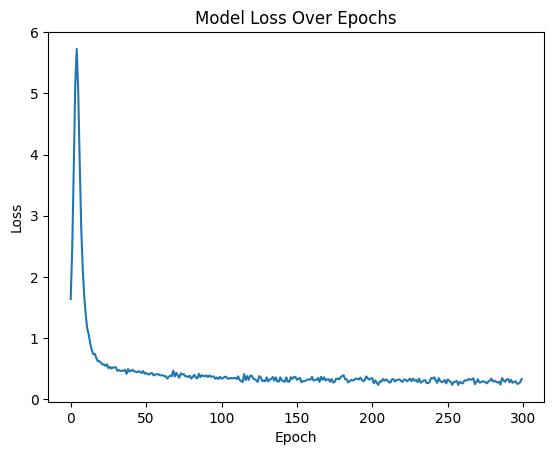

In [20]:
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [66]:
# Dummy input to build the model
dummy_user = np.array([0])  # Replace with an appropriate dummy value
dummy_item = np.array([0])  # Replace with an appropriate dummy value

# Run the model on dummy data in prediction mode
model([dummy_user, dummy_item], training=False)


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00224481]], dtype=float32)>

In [67]:
#model.save('/content/drive/MyDrive/Datasets/apr_model_test')
